In [11]:
import numpy as np
import cv2
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import glob
import random
import time
import pickle

from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy.ndimage.measurements import label

from helper_functions import *
from tracker import tracker
%matplotlib inline

In [12]:
def get_feature_extraction_params():
# Feature extraction parameters:
    color_space='YCrCb' # This is the color space that'd be used for feature extraction
    spatial_size= (32,32) # This is the size to which the image will be resized
    hist_bins= 16 # Number of bins in the color histogram
    orient= 9 #Number of orientation bins
    pix_per_cell= 8 # pixels per cell
    cell_per_block= 2 # Number of cells in each block
    hog_channel= 'ALL' # which channel of image to extract the hog features for
    spatial_feat= True # Whether we want to extract spatial features using binning
    hist_feat= True # Whether we want to extract color histogram features
    hog_feat= True # Whether we want to extract hog features
    vis = True
    return color_space, spatial_size, hist_bins, orient, pix_per_cell, cell_per_block, hog_channel, spatial_feat, hist_feat, hog_feat, vis


# Testing on test images
I have tested the trained classifier above on the provided test images
Note that, these are .jpg images and must be scaled. Following results were obtained:
- Sliding over the entire window got too many false detections. Especially on the trees
- When ymax and ymin was set to 400, 656, there were no detections on the trees, however, some detections were missing. Especially the white car on black road was not detected.
I tried combinations of overlap and window sizes. The combination overlap = 0.75 and window size = 64 gave the best results, but with one false detection.

In [13]:
svc_pickle = pickle.load( open( "svc_pickle/svc_pickle.p", "rb" ) )
svc = svc_pickle["svc"] 
X_scaler = svc_pickle["X_scaler"]

Testing on test images...
Number of test images: 6
Number of windows:  160
Number of windows:  160
Number of windows:  160
Number of windows:  160
Number of windows:  160
Number of windows:  160
Execution time:6.55


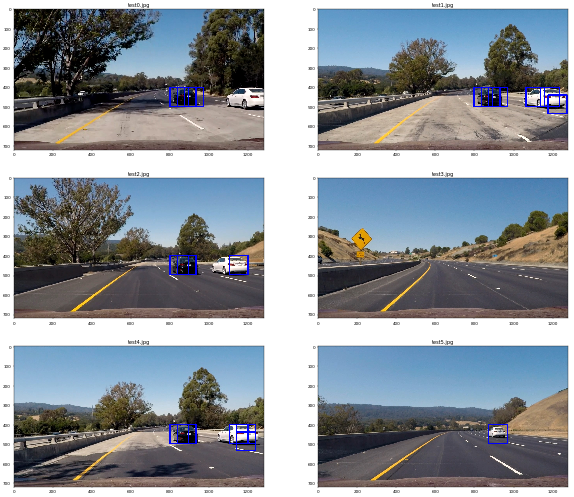

In [14]:
def detect_and_draw_boxes(test_images, clf, X_scaler, xy_overlap=(0.5,0.5), y_start_stop=[None, None], x_start_stop=[None, None], xy_window=(128, 128)):
    images = []
    titles = []
    t_total = 0

    for i, img_path in enumerate(test_images):
        t_start = time.time()
        image = mpimg.imread(img_path)
        #print(np.min(img), np.max(img))
        draw_image = np.copy(image)
        image = image.astype(np.float32)/255
        #print(np.min(img), np.max(img))

        # get a list of windows
        windows = slide_window(image, x_start_stop=x_start_stop, y_start_stop=y_start_stop, xy_window=xy_window, xy_overlap=xy_overlap)
        print("Number of windows: ", len(windows))
        # get the parameters
        color_space, spatial_size, hist_bins, orient, pix_per_cell, cell_per_block, hog_channel, spatial_feat, hist_feat, hog_feat, vis = get_feature_extraction_params()

        # find the windows for positive detections
        hot_windows = search_windows(image, windows, clf, X_scaler, color_space=color_space,
                            spatial_size=spatial_size, hist_bins=hist_bins,
                            orient=orient, pix_per_cell=pix_per_cell,
                            cell_per_block=cell_per_block,
                            hog_channel=hog_channel, spatial_feat=spatial_feat,
                            hist_feat=hist_feat, hog_feat=hog_feat)

        # Draw the hot window on the image
        window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)

        images.append(window_img)
        titles.append('test'+str(i)+'.jpg')

        t_total += time.time() - t_start
        
    return round(t_total,2), images, titles
    

print("Testing on test images...")    
test_images = glob.glob('./test_images/*.jpg')
print("Number of test images:", len(test_images))
xy_overlap = (0.6,0.6)
X_scaler = X_scaler # obtained in previous step
xy_window= (96, 96)
x_start_stop=[None, None]
y_start_stop = [400,656] #[None, None]
clf = svc # Trained classifier from previous step

t_total, images, titles = detect_and_draw_boxes(test_images, clf, X_scaler, xy_overlap, y_start_stop, x_start_stop, xy_window)

print('Execution time:{}'.format(t_total))
fig = plt.figure(figsize=(24,36), dpi=30)
visualize(fig, 5,2, images, titles)

## Extracting features with Hog subsampling

Using hog subsampling...
Execution time:4.933007717132568


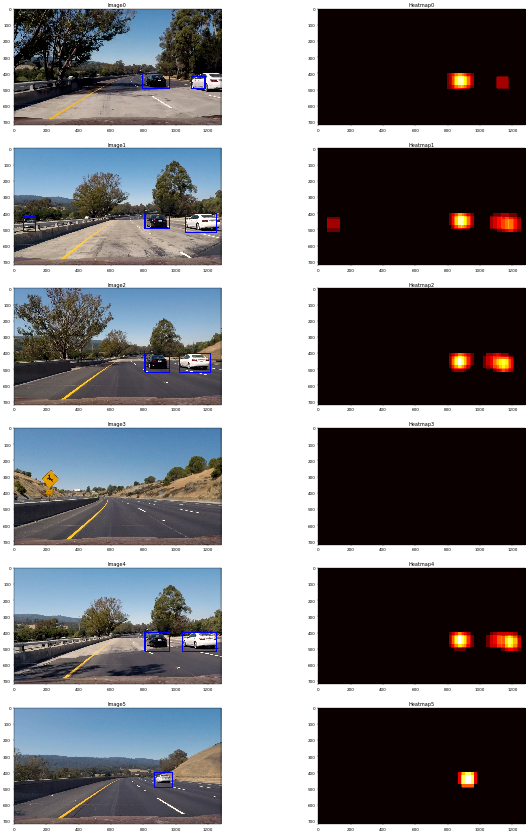

In [15]:
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    # meaning, if there have been < threshold 
    # number of box detections around  this pixel position
    # we'll consider this pixel position as false detection
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map. 
    return heatmap

def draw_boxes_with_cars(img, bboxes_carnumbers, color=(0, 0, 255), thick=6):
    #if not len(bboxes_carnumbers):
    #    print("Received an empty bboxes_carnumbers")
    # Make a copy of the image
    draw_img = np.copy(img)
    # Iterate through the bounding boxes
    for bbox_carnumber in bboxes_carnumbers:
        # Draw a rectangle given bbox coordinates
        bbox = bbox_carnumber[0]
        #print("drawing box at", bbox)
        cv2.rectangle(draw_img, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return draw_img

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    bboxes_carnumbers = []
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        bboxes_carnumbers.append((bbox,car_number)) # this way, bboxes[0] -> car1, bboxes[1] -> car2 and so on
    # Return the bounding boxes for all cars
    return bboxes_carnumbers

def convert_color(image, conv='RGB'):
    #print('converting color space')
    if conv != 'RGB':
        if conv == 'HSV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        elif conv == 'LUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
        elif conv == 'HLS':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        elif conv == 'YUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        elif conv == 'YCrCb':
            #print('converting to YCrCb')
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(image)
    
    return feature_image

# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, xy_window, window=64):
    
    #draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    conv, spatial_size, hist_bins, orient, pix_per_cell, cell_per_block, hog_channel, spatial_feat, hist_feat, hog_feat, vis = get_feature_extraction_params()
    count = 0
    #img_boxes = []
    t_start = time.time()

    
    img_tosearch = img[ystart:ystop,:,:]
    #print("shape of img_tosearch", img_tosearch.shape)
    ctrans_tosearch = convert_color(img_tosearch, conv=conv)
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    #print('pix_per_cell', pix_per_cell)
    nxblocks = (ch1.shape[1] // pix_per_cell)-1 # How many cells across the (cropped) image width
    #print('nxblocks', ch1.shape[1], '/', pix_per_cell, '=',nxblocks)
    nyblocks = (ch1.shape[0] // pix_per_cell)-1 # how many cells along the (cropped) image height
    #print('nyblocks', nyblocks)
    nfeat_per_block = orient*cell_per_block**2  # number of features that'll be extracted per block
    nblocks_per_window = (window // pix_per_cell)-1 
    #print('nblocks_per_window', nblocks_per_window)
    cells_per_step = 2  # (for 8x8 cell size, 2 will mean 75% overlap & 4 will mean, 50% overlap) 
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            count += 1
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch of size xy_window
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], xy_window)
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)
            #print("spatial_features shape:{}".format(spatial_features.shape))
            #print("hist_features shape:{}".format(hist_features.shape))
            #print("hog_features shape:{}".format(hog_features.shape))
            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                #cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                #img_boxes.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                heat[ytop_draw+ystart:ytop_draw+win_draw+ystart, xbox_left:xbox_left+win_draw] += 1
    t_exec = time.time() - t_start          
    #return draw_img, img_boxes, heat, t_exec
    return heat, t_exec

print("Using hog subsampling...")    
test_images = glob.glob('./test_images/*.jpg')
X_scaler = X_scaler # obtained in previous step. Otherwise you'd call extract_features_and_train_svm()
xy_window= (64, 64)
x_start_stop=[None, None]
ystart = 400
ystop = 656
scale1 = 1.5
scale2 = 1.2
clf = svc # Trained classifier from previous step
window = 64 # let's keep this at 64 always, because that's what we trained the SVC with
t_total = 0
out_images = []
out_heatmaps= []
titles = []

for i, img_path in enumerate(test_images):
    img = mpimg.imread(test_images[i])
    heat1, t_exec = find_cars(img, ystart, ystop, scale1, svc, X_scaler, xy_window, window)
    heat2, t_exec = find_cars(img, ystart, ystop, scale2, svc, X_scaler, xy_window, window)
    heat = heat1 + heat2
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,1)
    # Visualize the heatmap when displaying
    heatmap = np.clip(heat, 0, 255)
    # Find final boxes from heatmap using label function
    # Label function will return a two tuple
    # label[1] is the number of features found (in this case, number of cars)
    # label[0] will be a modified heatmap, where for feature 1, values are 1, feature 2, values are 2 and so on...
    labels = label(heatmap)
    bboxes_carnumbers = draw_labeled_bboxes(np.copy(img), labels)
    draw_img = draw_boxes_with_cars(img, bboxes_carnumbers)
    out_images.append(draw_img)
    titles.append("Image"+str(i))
    out_images.append(heatmap)
    titles.append("Heatmap"+str(i))
    t_total += t_exec
    
    
print('Execution time:{}'.format(t_total))
fig = plt.figure(figsize=(24,36), dpi=30)
visualize(fig, 6,2, out_images, titles)

## Processing the video
I will now process the project video with the function defined above with the values that are known to give good results

In [16]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [17]:
car_tracker = tracker()
scale1 = 1
scale2 = 1.2
scale3 = 1.5
scale4 = 1.8
scale5 = 2.0

structure = [[1,1,1], [1,1,1],[1,1,1]]


def process_image(img):
    heat1, t_exec = find_cars(img, ystart, ystop, scale1, svc, X_scaler, xy_window, window)
    heat2, t_exec = find_cars(img, ystart, ystop, scale2, svc, X_scaler, xy_window, window)
    heat3, t_exec = find_cars(img, ystart, ystop, scale3, svc, X_scaler, xy_window, window)
    heat4, t_exec = find_cars(img, ystart, ystop, scale4, svc, X_scaler, xy_window, window)
    heat5, t_exec = find_cars(img, ystart, ystop, scale5, svc, X_scaler, xy_window, window)
    
    heat = heat1+heat2+heat3+heat4+heat5
    
    draw_img = np.copy(img)
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,6) # was 4
    # Visualize the heatmap when displaying
    heatmap = np.clip(heat, 0, 255)
    # Find final boxes from heatmap using label function
    labels = label(heatmap, structure=structure)
    bboxes_carnumbers = draw_labeled_bboxes(np.copy(img), labels)
    #print("original bboxes_carnumbers: ", bboxes_carnumbers)

    #if len(bboxes_carnumbers):
    car_tracker.track(bboxes_carnumbers)
    bboxes_carnumbers = car_tracker.get_best_fit_bbox()
    #print("averaged bboxes_carnumbers: ", bboxes_carnumbers)
        #print("-------------------------------------------------")
    draw_img = draw_boxes_with_cars(img, bboxes_carnumbers)
    return draw_img

test_output = 'output_project_video.mp4'
clip2 = VideoFileClip('project_video.mp4') #.subclip(23, 25)
project_video = clip2.fl_image(process_image)
%time project_video.write_videofile(test_output, audio=False)

tracker initialized
[MoviePy] >>>> Building video output_project_video.mp4
[MoviePy] Writing video output_project_video.mp4


100%|█████████▉| 1260/1261 [1:05:34<00:03,  3.11s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_project_video.mp4 

CPU times: user 1h 9min 44s, sys: 22.1 s, total: 1h 10min 6s
Wall time: 1h 5min 35s
